In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd

/home/ec2-user/git-repos/skforecast


In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd

from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model, create_and_compile_model_exog, create_and_compile_model_exog_2

# set backend torch
import torch
import keras
print(keras.__version__)
print(keras.backend.backend())



3.7.0
torch


# Test with Ximo

In [3]:
from skforecast.datasets import fetch_dataset
data = fetch_dataset('bike_sharing_extended_features')

end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val = data.loc[end_train:end_validation, :]
data_test = data.loc[end_validation:, :]

exog_features = [ 'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin', 'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos', 'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day', 'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day', 'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day', 'temp', 'holiday' ]


bike_sharing_extended_features
------------------------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, the dataset
was enriched by introducing supplementary features. Addition includes calendar-
based variables (day of the week, hour of the day, month, etc.), indicators for
sunlight, incorporation of rolling temperature averages, and the creation of
polynomial features generated from variable pairs. All cyclic variables are
encoded using sine and cosine functions to ensure accurate representation.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17352, 90)


In [6]:
lags = 24
steps = 36
levels = ["users"]
activation = "relu"
# optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss = keras.losses.MeanSquaredError()
recurrent_units = 100
dense_units = [128, 64]

model = create_and_compile_model_exog_2(
    series=data[levels],
    lags=lags,
    steps=steps,
    levels=levels,
    exog=data[exog_features],
    recurrent_units=recurrent_units,
    dense_units=dense_units,
    activation=activation,
    # optimizer=optimizer,
    loss=loss,
)

model.summary()

# ==============================================================================

forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    fit_kwargs={
        "epochs": 300,  # Number of epochs to train the model.
        "batch_size": 2048,  # Batch size to train the model.
    },
)    


# Backtesting model with exogenous variables on test data 
# # ============================================================================== 
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries
 
cv = TimeSeriesFold( steps = 36, initial_train_size = len(data[:end_validation]), refit = False, allow_incomplete_fold=False)
metric, predictions = backtesting_forecaster_multiseries( forecaster = forecaster, series = data[levels], exog = data[exog_features], cv = cv, metric = 'mean_absolute_error' )

metric

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ series_input        │ (None, 24, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 100)       │     40,800 │ series_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 36, 100)   │          0 │ lstm_2[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exog_input          │ (None, 36, 22)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 36, 122)   │          0 │ repeat_vector_2[… │
│ (Concatenate)       │                   │            │ exog_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_6  │ (None, 36, 128)   │     15,744 │ concatenate_2[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_7  │ (None, 36, 64)    │      8,256 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 36, 1)     │         65 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 64,865 (253.38 KB)

 Trainable params: 64,865 (253.38 KB)

 Non-trainable params: 0 (0.00 B)

/home/ec2-user/git-repos/skforecast/venv_skforecast_0.15/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Using device: cuda
Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.2952
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0347
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0272
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0238
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0193
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0180
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0173
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0166
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0172
Epoch 10/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0154
Epoch 11/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0142
Epoch 12/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0130
Epoch 13/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0119
Epoch 14/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0108
Epoch 15/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step 

100%|██████████| 80/80 [00:03<00:00, 23.68it/s]


,levels,mean_absolute_error
0,users,233.71544


In [44]:
lags = 24
steps = 36
levels = ["users"]
activation = "relu"
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss = keras.losses.MeanSquaredError()
recurrent_units = 100
dense_units = [128, 64]

model = create_and_compile_model_exog_2(
    series=data[levels],
    lags=lags,
    steps=steps,
    levels=levels,
    # exog=data[exog_features],
    recurrent_units=recurrent_units,
    dense_units=dense_units,
    activation=activation,
    optimizer=optimizer,
    loss=loss,
)

model.summary()

# ==============================================================================

forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    fit_kwargs={
        "epochs": 3,  # Number of epochs to train the model.
        "batch_size": 2048,  # Batch size to train the model.
    },
)    


# Backtesting model with exogenous variables on test data 
# # ============================================================================== 
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries
 
cv = TimeSeriesFold( steps = 36, initial_train_size = len(data[:end_validation]), refit = False, allow_incomplete_fold=False)
metric, predictions = backtesting_forecaster_multiseries(
    forecaster = forecaster, 
    series = data[levels], 
    # exog = data[exog_features], 
    cv = cv, 
    metric = 'mean_absolute_error'
    )

metric

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 36, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 36, 128)        │        12,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 36, 64)         │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 36, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,049 (242.38 KB)

 Trainable params: 62,049 (242.38 KB)

 Non-trainable params: 0 (0.00 B)

/home/ec2-user/git-repos/skforecast/venv_skforecast_0.15/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Using device: cpu
Epoch 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - loss: 0.0716
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - loss: 0.0363
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - loss: 0.0324





























100%|██████████| 80/80 [00:02<00:00, 29.39it/s]


,levels,mean_absolute_error
0,users,170.711783


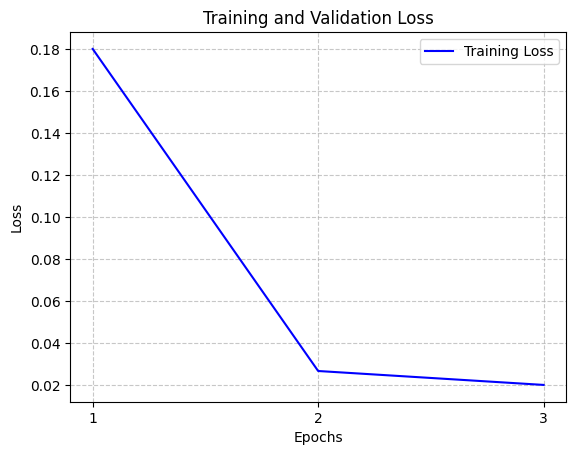

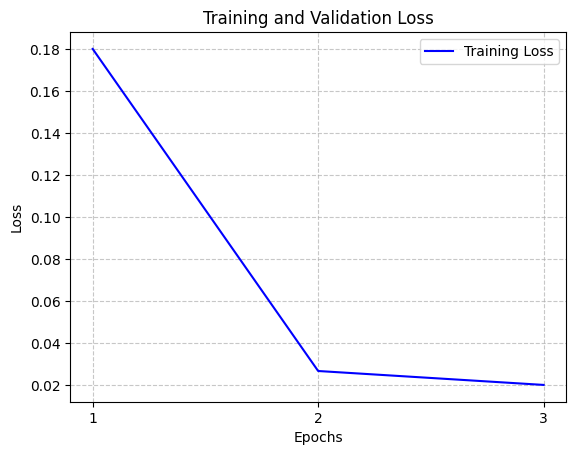

In [28]:
forecaster.plot_history()